In [1]:
import pandas as pd
import utils
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from ast import literal_eval
import spotipy
import os

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

# Introduction

In this notebook we will explore a data set of the entirety of my saved songs and playlists in Spotify, along with features and statistics on each song (some already computed and extracted from the Spotify API, others computed from 30 seconds samples of the song and Librosa). 

Specifically, we will explore the make up of my Spotify playlists to deduce if we can recommend new songs to add to each playlist from my saved songs. If a user has been using Spotify for many years, it is likely that their liked songs contain songs enjoyed throughout the years, with songs that were enjoyed a long time ago buried deep in a stack of songs that were enjoyed more recently. This tool aims to help identify songs that the user enjoyed in the past but has likely forgotten about, and recommend songs that would fit well into a playlist that user is currently creating. This tool can also help the user identify songs that share similarity to recent listening trends that the user has either neglected or failed to realize. In this light, the user can find novel connections within their "footprint" of Spotify tracks they listen to and better understand what drives their internal song rating system. 

By recommending from a user's saved songs rather than Spotify's library at large, we can be sure that any song recommended will be one that the user has already enjoyed at some point. Because of this, songs are recommended on what may be the user's native ranking system, adapting to the genre specific nuances of a playlist that may not reflect Spotify's definition of the same genres. Playlists that represent a general feel or tone that transcends specific genres can be captured just as well -- succesfully identifying liked songs that mirror this feel or tone. 

Lastly, I have found that this recommendation system leads to nostalgic experiences, as the recommended songs are frequently ones that I haven't listened to in years, triggering memories from the time period in which I regularly listened to each recommended track.

`saved_tracks.csv` contains the entirety of my saved tracks library, collected using `extract_saved_tracks_data.ipynb`

`output/playlists` contains a .csv file containing the tracks and features for each of my playlists currently being tracked, collected using `extract_playlist_data.ipynb`

In [2]:
saved_tracks = pd.read_csv('output/saved_tracks.csv', index_col = 'track_key')
# As a result of storing as a .csv file, lists are stored as strings, so we must convert back
saved_tracks['artist_genres'] = saved_tracks['artist_genres'].apply(lambda x : literal_eval(x))

In [3]:
files = [x[:-4] for x in os.listdir('output/playlists') if x.endswith('.csv')]
print(files)

['The AFTER party', 'Bodzin Disco', 'Love songs', 'Molasses Music', 'Dune Juuz', 'The after after party', 'Jamie Jones Boiler Room Ibiza Villa', 'The Stick', 'Deep dish', 'chillin with the bill', 'Seinfeld Haul', 'Things DnB makes me do']


The names of the playlists currently being tracked are listed above. I will choose to explore my playlist entitled `Dune Juuz` in this notebook, which I consider to contain songs that I feel have notable "psychedelic influence" from genres including alternative, electronic, bedroom pop, and others. 

I will be recommending tracks from my saved songs that fit will into this playlist, essentially identifying songs that I may consider to be under psychedelic influence. In this way, songs are recommended based on the listener's subjective measure of what is considered psychedelic. This is superior to recommendation based on an objective measure because it ensures recommendations will be specific to each listener, while the ladder may lead to the recommendation of songs that may objectively be psychedelic but subjectively not to a specific listener. 

In [4]:
playlist_name = 'Dune Juuz'
playlist_original = pd.read_csv(f'output/playlists/{playlist_name}.csv', index_col = 'track_key')
# As a result of storing as a .csv file, lists are stored as strings, so we must convert back
playlist_original['artist_genres'] = playlist_original['artist_genres'].apply(lambda x: literal_eval(x))

In [5]:
playlist_original.shape

(913, 435)

## The Data
The `saved_tracks` table includes the entirety of my saved tracks library since my account's conception in 2014 to today's date: September 13th, 2021. Additional features have been pulled using the [Spotify Web API](https://developer.spotify.com/documentation/web-api/reference/) and by processing 30 second samples of each song using the [Librosa](https://librosa.org) library. The process of collecting features can be viewed in `extrasct_saved_tracks_data.ipynb`

Columns of the `saved_tracks` table include:

Identification metrics: 
- `track_key`: Unique key generated from a combination of track name and artist name 
- `track_name`: Name of the track
- `artist_name`: Name of the track's primary artist
- `album_name`: Name of the album that the track is from
- `track_id`: Spotify ID of the track
- `artist_id`: Spotify ID of the track's artist
- `album_id`: Spotify ID of the album from which the track is from
- `added_at`: The time at which the track was added to my saved songs

Spotify API Track Audio Features:
- `danceability`: How suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity (a value of 0.0 is least danceable and 1.0 is most danceable)
- `energy`: A measure from 0.0 to 1.0 that represents a perceptual measure of intensity and activity (a value of 1.0 represents high energy)
- `key`: The key the track is in (integers map to pitches using standard Pitch Class notation)
- `loudness`: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.
- `mode`: The modality (major or minor) of a track, the type of scale from which its melodic content is derived (Major is represented by 1 and minor is 0)
- `speechiness`: Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.
- `acousticness`: A confidence measure from 0.0 to 1.0 of whether the track is acoustic (1.0 represents high confidence the track is acoustic)
- `instrumentalness`: Predicts whether a track contains no vocals.“Ooh” and “aah” sounds are treated as instrumental in this context (a score of 1.0 represents a greater likelihood that the track contains no vocals)
- `liveness`: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
- `valence`: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- `tempo`: The overall estimated tempo of a track in beats per minute (BPM) (tempo is the speed or pace of a given piece)
- `duration_ms`: The duration of the track in milliseconds
- `time_signature`: Estimated overall time signature, or notational convention to specify how many beats are in each bar (or measure)of a track

30 Second Sample Calculated Audio Features:
- `tempo_calc`: The calculated tempo of the track's sample
- `zcr`*: The zero crossing rate (rate at which a signal changes its sign from positive to negative or vice versa; good at extracting information about percussive sounds)
- `mfccs`*: The first 13 Mel Frequency Cepstral Coefficients (a cepstral representation of the short-term power spectrum of the track's sample)
- `spectral_contrast`*: the decibel difference between peaks and valleys in the spectrum (captures the time-varying behavior of the track's sample)
- `chroma`*: a condensed representation of sound in which the entire spectrum is projected onto the 12 distinct semitones / chroma of the musical octave (captures harmonic and melodic elements of music)
- `tonnetz`*: maps an audio clip to a standard representation of the tonal landscape (used to capture harmonic motion between chords and modulation between keys)
- `spectral_flatness`*: a measure to quantify how close an audio clip is to being pure noise (captures how tonal vs. noisy the audio clip is)
- `rms`*: The root mean square of the audio signal representing its "average" (captures the loudness and strength of the signal)
- `spectral_centroid`*: Characterizes where the center of mass of the audio clips spectrum is (has been shown to have a robust connection with the impression of brightness of a sound)
- `spectral_bandwidth`*: The variance from the spectral centroid of an audio signal
- `energy`*: similar to the Spotify API's `energy` feature in that it attempts to capture the intensity and activity of the audio clip


\* indicates that the first 5 moments of the features distribution were stored to maintain optimal space efficiency, along with the standard deviation, minimum, maximum, median

Other:
- `artist_genres`: A list of the genres the artist is associated with

Popularity Metrics: 
- `track_popularity`: Spotify's representation of the popularity of the track between 0 and 100, with 100 being the most popular
- `album_popularity`: Spotify's representation of the popularity of the album from which the track comes from between 0 and 100, with 100 being the most popular
- `artist_popularity`: Spotify's representation of the popularity of the artist the track is by between 0 and 100, with 100 being the most popular
- `artist_followers`: The number of followers that the artist has on Spotify

In [6]:
saved_tracks = saved_tracks.sort_values('added_at', ascending = False)
saved_tracks.head()

track_name artist_name                               album_name                track_id               artist_id                album_id                 artist_genres  artist_followers  artist_popularity  album_popularity                                        preview_url  danceability  energy  key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  valence    tempo  duration_ms  time_signature  track_popularity              added_at  tempo_calc  energy_mean    energy_var  energy_std  energy_min  energy_max  energy_median  energy_kurt  energy_skew  rms_mean   rms_var   rms_std   rms_min   rms_max  rms_median  rms_kurt  rms_skew  zcr_mean   zcr_var   zcr_std   zcr_min   zcr_max  zcr_median  zcr_kurt  zcr_skew  spec_flat_mean  spec_flat_var  spec_flat_std  spec_flat_min  spec_flat_max  spec_flat_median  spec_flat_kurt  spec_flat_skew  spec_cent_mean  spec_cent_var  spec_cent_std  \
track_key                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Soared Straight Through Me___Tom VR                                    Soared Straight Through Me      Tom VR               Soared Straight Through Me  25fJ3wk2D8UlmjgITbH6BT  36tUphbhaRrmHNS6reORr5  6lK03JWlIqUt5H3Zg4EQCu    [float house, lo-fi house]              4048                 34                16  https://p.scdn.co/mp3-preview/b5361b466b50eca1...         0.596   0.885    2   -10.320     1       0.0698       0.00708             0.833    0.2410    0.031  127.022       385000               4                24  2021-09-20T06:15:03Z  129.199219   219.990859   1883.598717   43.400446   38.356636  454.531466     221.473248     7.624682     0.800932  0.326161  0.001075  0.032787  0.136853  0.471104    0.328862  6.467152 -0.446412  0.051541  0.000331  0.018186  0.010742  0.167480    0.049316  6.060533  1.705398        0.012486       0.000154       0.012405   3.263812e-04       0.089436          0.007873        3.081509        1.604591     2279.169960   3.939146e+05     627.626175   
Bird Whisperer___Tom VR                                                            Bird Whisperer      Tom VR                                 Frissons  02iG4hNHYRA3EPwZzjUcHz  36tUphbhaRrmHNS6reORr5  0ewKvRP0v6h2igvxJqs3rM    [float house, lo-fi house]              4048                 34                17  https://p.scdn.co/mp3-preview/5e83f0fe2c5c0d9c...         0.836   0.532    0   -10.420     0       0.0732       0.07350             0.888    0.0657    0.638  118.058       521773               4                26  2021-09-20T06:07:04Z  117.453835   264.434860  21482.361695  146.568625   39.265715  723.505067     211.674993     0.342504     1.143099  0.347485  0.008576  0.092606  0.158925  0.594369    0.321638 -0.317799  0.760300  0.027681  0.000301  0.017362  0.004395  0.134766    0.024414  6.190038  2.066822        0.003720       0.000038       0.006147   4.307909e-05       0.063841          0.001072       19.183712        3.545495     1869.577551   6.050008e+05     777.817961   
October___Tom VR                                                                          O

In [7]:
playlist_original = playlist_original.sort_values('added_at', ascending = False)
playlist_original.head()

track_name      artist_name                          album_name                track_id               artist_id                album_id                          artist_genres  artist_followers  artist_popularity  album_popularity                                        preview_url  danceability  energy  key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  valence    tempo  duration_ms  time_signature  track_popularity              added_at  tempo_calc  energy_mean   energy_var  energy_std  energy_min  energy_max  energy_median  energy_kurt  energy_skew  rms_mean   rms_var   rms_std   rms_min   rms_max  rms_median  rms_kurt  rms_skew  zcr_mean   zcr_var   zcr_std   zcr_min   zcr_max  zcr_median  zcr_kurt  zcr_skew  spec_flat_mean  spec_flat_var  spec_flat_std  spec_flat_min  spec_flat_max  spec_flat_median  spec_flat_kurt  spec_flat_skew  spec_cent_mean  spec_cent_var  spec_cent_std  spec_cent_min  \
track_key                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Right Where You Ought to Be___Mr. Elevator   Right Where You Ought to Be     Mr. Elevator  Nico & Her Psychedelic Subconcious  2M4St7SooF0WgupqbHYekE  0PGODrsM5deGDeEWd77qjk  3j30jsSn2em6L6xXhGTibv                      [neo-psychedelic]              3999                 26                30  https://p.scdn.co/mp3-preview/f417f56e2987be81...         0.441   0.839   10    -7.787     1       0.0348       0.00286          0.000183    0.4120    0.900  133.479       212093               4                15  2021-09-14T18:41:17Z  135.999178    87.549630   893.211602   29.886646   18.579101  181.264397      82.702641    -0.075999     0.605072  0.203848  0.001217  0.034884  0.097987  0.297503    0.200953 -0.291027  0.209704  0.161433  0.002681  0.051777  0.072754  0.420898    0.148438  4.344595  1.808176        0.052283       0.001156       0.033996   7.000950e-03       0.287823          0.044080        6.451153        2.012833     3054.495851  331149.436271     575.455851    1994.731588   
Silhouettes (I, II & III)___Floating Points    Silhouettes (I, II & III)  Floating Points                             Elaenia  13LqCh4tcyxDJbALYVCN8b  2AR42Ur9PcchQDtEdwkv4L  0SDLAAGQmK8DWxkX0s9OGE  [bass music, electronica, microhouse]            234571                 53                31  https://p.scdn.co/mp3-preview/3e9684d7116b513d...         0.637   0.494    5   -10.735     0       0.0430       0.25300          0.876000    0.0722    0.118  135.009       642653               4                28  2021-09-13T17:07:49Z   89.102909   270.585659  7786.948875   88.243690   46.190553  484.882205     274.937674    -0.548602    -0.141445  0.358263  0.003953  0.062877  0.150180  0.486579    0.366621 -0.016307 -0.578477  0.076142  0.000160  0.012657  0.035156  0.127441    0.072754  1.231512  1.012053        0.006559       0.000022       0.004672   1.150179e-03       0.034083          0.005141        4.451987        1.824710     1954.398179   73444.703155     271.006832    1349.983880   
Alone Together___Mr. Elevator                             Alone Together  

# Exploratory Data Analysis

In [8]:
import datetime as dt

Let's first look at the genre make up of the playlist at hand as compared to my saved tracks:

In [9]:
# Collect all genres within the playlist
playlist_genres_list = []
for index, row in playlist_original.iterrows():
    artist_genres = row['artist_genres']
    for genre in artist_genres:
        playlist_genres_list.append(genre)
        
# Collect all genres within the saved tracks
saved_tracks_genres_list = []
for index, row in saved_tracks.iterrows():
    artist_genres = row['artist_genres']
    for genre in artist_genres:
        saved_tracks_genres_list.append(genre)

In [10]:
playlist_genre_series = pd.Series(playlist_genres_list)
playlist_genre_series.value_counts()[:20]

indie soul           186
neo-psychedelic      174
chillwave            130
alternative dance    124
new rave             116
electronica           98
indie rock            96
indietronica          96
indie garage rock     72
alternative r&b       70
hip hop               68
rock                  67
australian psych      61
indie pop             53
rap                   53
modern rock           52
vapor soul            40
indie jazz            37
dream pop             32
classic rock          32
dtype: int64

In [11]:
saved_tracks_genre_series = pd.Series(saved_tracks_genres_list)
saved_tracks_genre_series.value_counts()[:20]

rap                    1667
hip hop                1434
indie soul             1230
electronica            1023
trap                    609
pop rap                 604
rock                    597
underground hip hop     595
float house             544
chillwave               544
alternative hip hop     522
alternative dance       519
escape room             514
neo-psychedelic         487
indie garage rock       486
new rave                474
southern hip hop        442
pop                     428
indie rock              428
alternative r&b         403
dtype: int64

As we can see, `Dune Juuz` is made up of music with a more "psychedelic" influence than my saved tracks at large. Certain genres such as "rap" and "hip hop", which are the two most populous genres of my saved tracks are not nearly as populous in `Dune Juuz`.

Let's now look at the distributions of the different features collected for each song to get a better idea of what might set the sound of `Dune Juuz` apart from my saved tracks. 

In [12]:
def plot_kdeplot(column_name, plot_title):
    '''
    Plots the distributions of the column whose name is passed as an argument for both saved tracks and 
    playlist.
    '''
    sns.set(rc={'figure.figsize':(9,6)}, style = 'white')
    sns.kdeplot(playlist_original[column_name], color = 'b', fill = True, label = 'Dune Juuz')
    sns.kdeplot(saved_tracks[column_name], color = 'r', fill = True, label = 'Saved Tracks').set(title = plot_title)
    
    # collect means and plot
    x_mu_play = np.mean(playlist_original[column_name])
    x_mu_saved = np.mean(saved_tracks[column_name])
    plt.plot(x_mu_play,0, 'b', marker = 7, ms=15, alpha = 0.7)
    plt.plot(x_mu_saved,0, 'r', marker = 7, ms=15, alpha = 0.7)
    plt.legend()

In each kernel density estimation plot below, the blue distribution represents `Dune Juuz` while the red distribution represents `Saved Tracks`. The triangles at the bottom of the plot mark the center of mass of each distribution.

Let's examine the distribution of the `added_at` feature of `saved_tracks` and `playlist_original`:

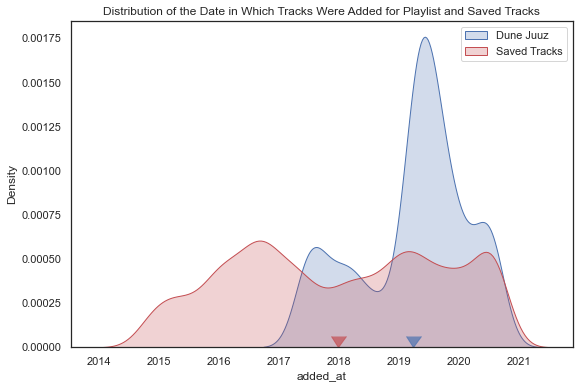

In [13]:
# Convert the 'added_at' feature into a datetime object that is converted to my local timezone for plotting
local_time = pd.to_datetime(playlist_original['added_at'],
               format = '%Y-%m-%d %H:%M').dt.tz_convert(tz = 'US/Pacific')
playlist_original['added_at'] = local_time
local_time_2 = pd.to_datetime(saved_tracks['added_at'],
               format = '%Y-%m-%d %H:%M').dt.tz_convert(tz = 'US/Pacific')
saved_tracks['added_at'] = local_time_2

plot_kdeplot('added_at', 'Distribution of the Date in Which Tracks Were Added for Playlist and Saved Tracks')

From the plot above, we can already see what was mentioned in the introduction -- that Spotify users who have been using Spotify for many years likely have a whole library of saved tracks that dates long before the creation of many of their playlists. 
- From the distribution of `Dune Juuz`, we can see this playlist was created around the end of 2016. Meanwhile, `saved_tracks` have been accumulating since early 2014. 
- We want to mine these earlier saved tracks for songs that would fir well into `Dune Juuz`. 
- We want to identify tracks that may have been saved after the creation of the playlist that the user neglected to realize would fit well into the playlist.

Let's explore the distribution of some audio features of these songs now:

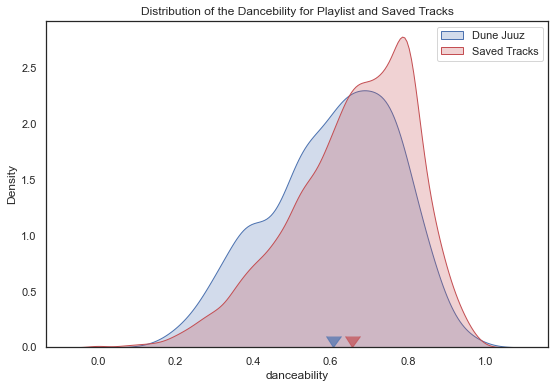

In [14]:
# On average, songs in Dune Juuz are slightly less danceable than songs in my saved tracks
plot_kdeplot('danceability', 'Distribution of the Dancebility for Playlist and Saved Tracks')

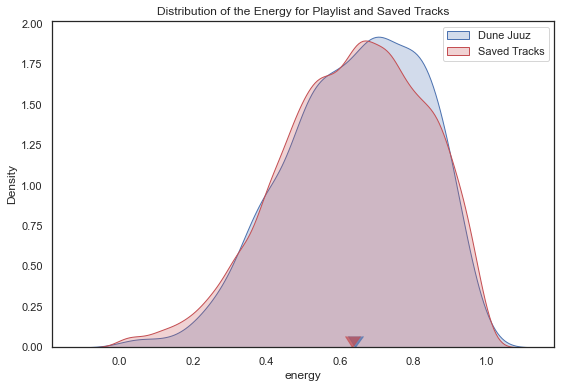

In [15]:
# On average, songs in Dune Juuz have about the same energy as songs in my saved tracks
plot_kdeplot('energy', 'Distribution of the Energy for Playlist and Saved Tracks')

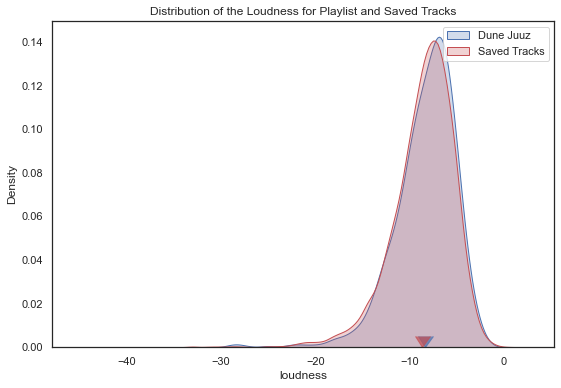

In [16]:
# On average, songs in Dune Juuz have about the same loudness as songs in my saved tracks
plot_kdeplot('loudness', 'Distribution of the Loudness for Playlist and Saved Tracks')

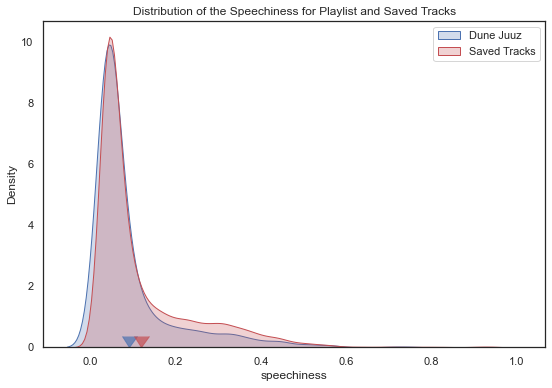

In [17]:
# On average, songs in Dune Juuz are slightly less speechy than songs in my saved tracks
plot_kdeplot('speechiness', 'Distribution of the Speechiness for Playlist and Saved Tracks')

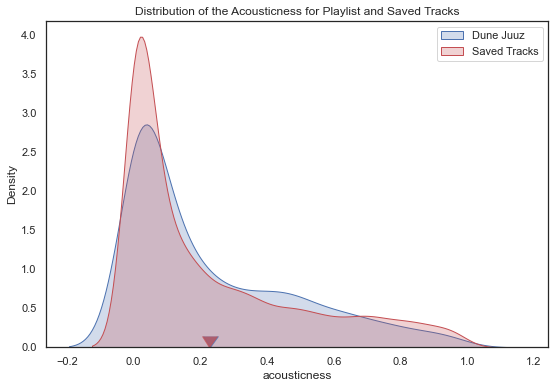

In [18]:
# On average, songs in Dune Juuz have about the same acousticness as songs in my saved tracks
plot_kdeplot('acousticness', 'Distribution of the Acousticness for Playlist and Saved Tracks')

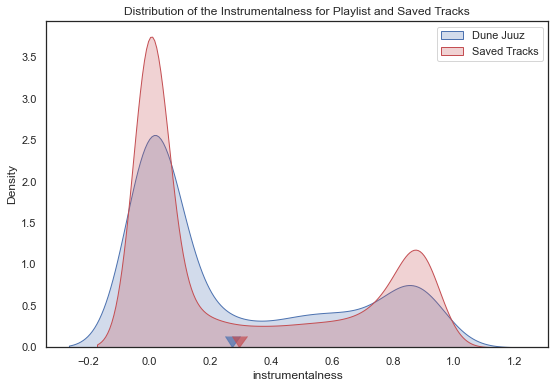

In [19]:
# On average, songs in Dune Juuz are slightly less instrumental than songs in my saved tracks
plot_kdeplot('instrumentalness', 'Distribution of the Instrumentalness for Playlist and Saved Tracks')

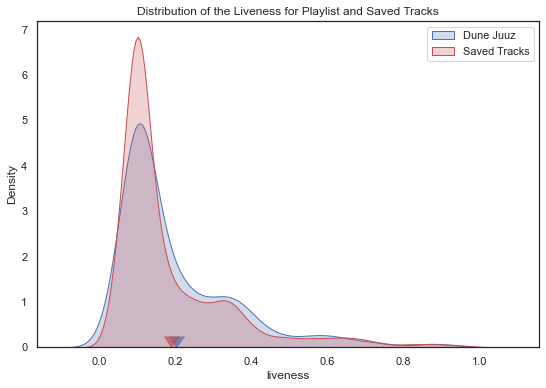

In [20]:
# On average, songs in Dune Juuz have a slightly larger liveness than songs in my saved tracks
plot_kdeplot('liveness', 'Distribution of the Liveness for Playlist and Saved Tracks')

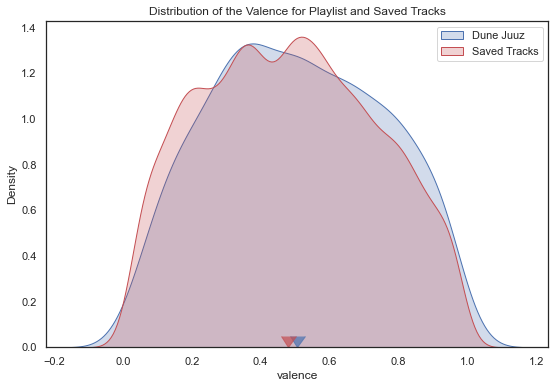

In [21]:
# On average, songs in Dune Juuz have a slightly larger valence than songs in my saved tracks
plot_kdeplot('valence', 'Distribution of the Valence for Playlist and Saved Tracks')

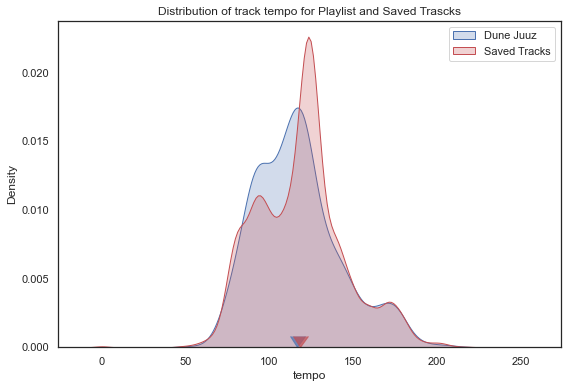

In [22]:
# On average, songs in Dune Juuz have about the same tempo as songs in my saved tracks
plot_kdeplot('tempo', 'Distribution of track tempo for Playlist and Saved Trascks')

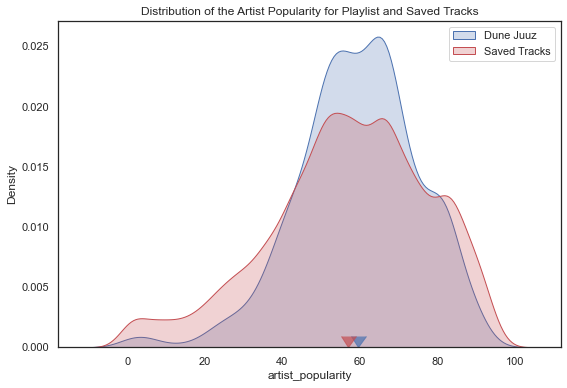

In [23]:
# On average, songs in Dune Juuz slightly more popular artists than songs in my saved tracks
plot_kdeplot('artist_popularity', 'Distribution of the Artist Popularity for Playlist and Saved Tracks')

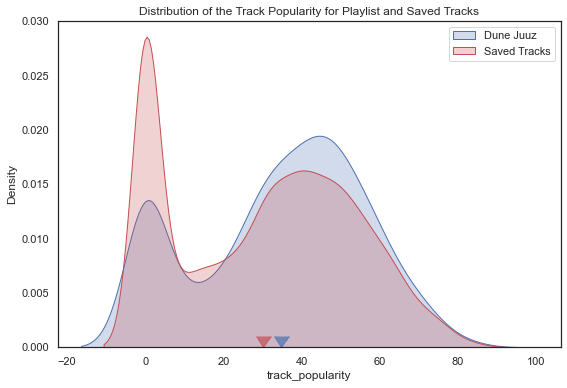

In [24]:
# On average, songs in Dune Juuz are slightly more popular than songs in my saved tracks
plot_kdeplot('track_popularity', 'Distribution of the Track Popularity for Playlist and Saved Tracks')

We have seen that tracks in `Dune Juuz` and `Saved Tracks` differ in some respects and remain relatively similar in other respects. We did not plot any distributions of the calculated audio features because they are much less interpretable. 

We hope to capture some of these defining differences as a way to identify songs that would fit well into the sound of `Dune Juuz`

# Feature Engineering and Data Preperation

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

### Binarizing `artist_genres`

By Binarizing the `artist_genres` feature of each song, we can use indicator variables of each unique genre as a feature to recognize similar songs. Below is an example of the artist genres for most recent track in `saved_tracks`.

In [26]:
saved_tracks.iloc[0]['artist_genres']

['float house', 'lo-fi house']

Rather than treating the multi-word genres as one genre, we will split each genre into its individual constituents, to prevent hyper-specific genres from being isolated from songs that may sound similar.

For example, if we consider the genre 'denton tx indie', it is hyper-specific in the sense that it restricts the genre 'indie' to only songs from Denton, Texas. By splitting 'denton tx indie' into its constituents, songs from this genre can be associated with any other song that has 'indie' as one of its genre's constituents rather than only songs with the same 'denton tx indie' label for genre.

An example outcome of the process described above is shown below. Notice how the genres have been reduced to individual words.

In [27]:
[item for sublist in map(lambda x: x.split(' '), saved_tracks.iloc[0]['artist_genres']) for item in sublist]

['float', 'house', 'lo-fi', 'house']

Now we are ready to binarize the constituents of artist genres for each genre

In [28]:
def find_all_constituents(columns):
    '''
    Collects a set of all uique constituents from the columns passed in.
    '''
    
    genres_set = set()
    for column in columns:
        for genre_list in column:
            genre_list = [item for sublist in map(lambda x: x.split(' '), genre_list) for item in sublist]
            for genre in genre_list:
                genres_set.add(genre)
    all_genres = list(genres_set)
    return all_genres

In [29]:
all_genres = find_all_constituents([saved_tracks['artist_genres'], playlist_original['artist_genres']])

In [30]:
print(f'Your saved tracks and playlist come from {len(all_genres)} unique genre constituents')

Your saved tracks and playlist come from 798 unique genre constituents


Now, let's define some functions to binarize the genres associated with each song:

In [31]:
def binarize_genre(df, all_genres):
    '''
    Binarizes the 'artist_genres' feature of each song so that these hots can be used as a feature
    in rccommendation.
    '''
    
    mlb = MultiLabelBinarizer()
    mlb.fit([all_genres])
    
    bow_encoding = pd.DataFrame(
        mlb.transform([[item for sublist in [genre.split(' ') for genre in genres] 
                        for item in sublist] for genres in df['artist_genres']]),
        columns=mlb.classes_,
        index = df.index)
    return bow_encoding

In [32]:
def center_standard(saved_tracks, playlist):
    '''
    Standardizes both the saved_tracks and playlist data frames.
    '''

    scaler = StandardScaler()
    scaler = scaler.fit(playlist)
    playlist_scaled_values = scaler.transform(playlist)
    saved_tracks_scaled_values = scaler.transform(saved_tracks)
    
    playlist_scaled = pd.DataFrame(playlist_scaled_values, columns = playlist.columns,
                                   index = playlist.index)
    
    saved_tracks_scaled = pd.DataFrame(saved_tracks_scaled_values, columns = saved_tracks.columns,
                                   index = saved_tracks.index)
    
    return saved_tracks_scaled, playlist_scaled

In [33]:
def prep_data(saved_tracks, playlist, columns_to_drop):
    '''
    Prepares both the saved_tracks and playlist DataFrames by re-indexing, binarizing 'artist_genres', 
    dropping columns in columns_to_drop, and standardizing the data.
    '''
    
    # binarize 'artist_genres'
    all_genres = find_all_constituents([saved_tracks['artist_genres'],
                                        playlist['artist_genres']])
    
    # re-index data and drop columns
    saved_tracks.index = [saved_tracks['track_name'], saved_tracks['artist_name'], saved_tracks['track_id']]
    saved_tracks_binarized = binarize_genre(saved_tracks, all_genres)
    saved_tracks = saved_tracks.drop(columns_to_drop, axis = 'columns').copy()
    
    playlist.index = [playlist['track_name'], playlist['artist_name'], playlist['track_id']]
    playlist_binarized = binarize_genre(playlist, all_genres)
    playlist = playlist.drop(columns_to_drop, axis = 'columns').copy()
    
    # standardize the data
    saved_tracks, playlist = center_standard(saved_tracks, playlist)
    
    saved_tracks = saved_tracks.join(saved_tracks_binarized)
    playlist = playlist.join(playlist_binarized)
    
    return saved_tracks, playlist

Because we will be trying to identify songs that we already like, but have not added to a playlist yet, we should consider our features in that light. 
- While including more general identification metrics such as `album_name` and `artist_name` may lead to songs with high similarity (due to them being from the same album or artist), this will restrict our recommendations too narrow. More general metrics such as the tracks audio features or the binarized `artist_genres` will be better to use.
- Other identification metrics like `track_id`, `artist_id`, and `album_id` will be of no use to us as a feature as they are only defined for interaction with Spotify's API,
- If we include popularity metrics such as `artist_followers` and `track_popularity`, our recommended songs will likely fall in the same popularity tier, which will discriminate against tracks that may sound similar, but do not share similar popularity.

In [34]:
columns_to_drop = ['track_name', 'artist_name', 'album_name', 'track_id', 'artist_id', 'album_id',
                   'artist_genres', 'preview_url', 'key', 'mode', 'time_signature', 'added_at',
                  'artist_followers', 'artist_popularity', 'album_popularity', 'track_popularity']

In [35]:
saved_tracks_prepped, playlist_prepped = prep_data(saved_tracks, playlist_original, columns_to_drop)

In [36]:
saved_tracks_prepped = saved_tracks_prepped.dropna()
saved_tracks_prepped.head()

danceability    energy  loudness  speechiness  acousticness  instrumentalness  liveness   valence     tempo  duration_ms  tempo_calc  energy_mean  energy_var  energy_std  energy_min  energy_max  energy_median  energy_kurt  energy_skew  rms_mean   rms_var   rms_std   rms_min   rms_max  rms_median  rms_kurt  rms_skew  zcr_mean   zcr_var   zcr_std   zcr_min   zcr_max  zcr_median  zcr_kurt  zcr_skew  spec_flat_mean  spec_flat_var  spec_flat_std  spec_flat_min  spec_flat_max  spec_flat_median  spec_flat_kurt  spec_flat_skew  spec_cent_mean  spec_cent_var  spec_cent_std  spec_cent_min  spec_cent_max  spec_cent_median  spec_cent_kurt  spec_cent_skew  spec_band_mean  spec_band_var  spec_band_std  spec_band_min  spec_band_max  spec_band_median  spec_band_kurt  spec_band_skew  mfcc1_mean  mfcc1_var  mfcc1_std  mfcc1_med  mfcc1_min  mfcc1_max  mfcc1_kurt  mfcc1_skew  mfcc2_mean  mfcc2_var  mfcc2_std  mfcc2_med  \
track_name                                    artist_name track_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
Soared Straight Through Me                    Tom VR      25fJ3wk2D8UlmjgITbH6BT     -0.069092  1.321839 -0.591111    -0.212734     -0.880725          1.636825  0.245236 -1.933070  0.406936     1.228517    0.369674     1.291690   -0.785572   -1.001508    1.637540    0.157313       1.546299     3.101862    -0.090411  1.407102 -1.166592 -1.583550  1.217608  0.248173    1.426946  5.696684 -1.097431 -1.266083 -0.994129 -1.454753 -0.393417 -1.215322   -1.067751  0.172076  0.273910       -0.345280      -0.629405      -0.696537       0.051485      -0.893711         -0.105968       -0.579044       -0.989560        0.380677      -0.369241      -0.255501       0.642798      -0.563655          0.407059       -0.750614       -0.639306        1.256581      -0.564157      -0.523414       1.379222       0.285992          1.262213       -0.924986       -0.613265    0.660676  -0.925359  -1.173424   0.493628   1.375147  -0.131665   -0.337304    1.014685   -0.526487  -0.816448  -0.883823  -0.496149   
Bird Whisperer                                Tom VR      02iG4hNHYRA3EPwZzjUcHz      1.402190 -0.594332 -0.621624    -0.179422     -0.617517          1.797493 -0.846960  0.534930  0.056961     2.646510   -0.095428     2.038692    1.648164    1.675209    1.694610    1.782176       1.386521    -0.242315     0.430021  1.778416  0.455979  0.622998  1.625429  1.632977    1.309532 -0.307809  1.006379 -2.077477 -1.008379 -1.499324 -0.918580 -1.467938   -1.913271  0.189339  0.628450       -1.111305      -0.785901      -1.183803      -0.364325      -1.212217         -0.919823        0.152396        0.272032       -0.503793       0.242627       0.407272      -0.549834      -0.232938         -0.426490       -0.445938       -0.246760        1.508447       0.194885       0.366176       0.976221       0.767918          1.460144       -0.576337       -0.462945   -1.234379   0.457086   0.651044  -1.566054  -0.313217  -0.725821   -0.217210    1.369426   -0.620497  -0.024848   0.120735  -0.491932   
October                                       Tom VR      20yRqzq5FEzgirJAUT4TIr     -1.48

In [37]:
playlist_prepped = playlist_prepped.dropna()
playlist_prepped.head()

danceability    energy  loudness  speechiness  acousticness  instrumentalness  liveness   valence     tempo  duration_ms  tempo_calc  energy_mean  energy_var  energy_std  energy_min  energy_max  energy_median  energy_kurt  energy_skew  rms_mean   rms_var   rms_std   rms_min   rms_max  rms_median  rms_kurt  rms_skew  zcr_mean   zcr_var   zcr_std   zcr_min   zcr_max  zcr_median  zcr_kurt  zcr_skew  spec_flat_mean  spec_flat_var  spec_flat_std  spec_flat_min  spec_flat_max  spec_flat_median  spec_flat_kurt  spec_flat_skew  spec_cent_mean  spec_cent_var  spec_cent_std  spec_cent_min  spec_cent_max  spec_cent_median  spec_cent_kurt  spec_cent_skew  spec_band_mean  spec_band_var  spec_band_std  spec_band_min  spec_band_max  spec_band_median  spec_band_kurt  spec_band_skew  mfcc1_mean  mfcc1_var  mfcc1_std  mfcc1_med  mfcc1_min  mfcc1_max  mfcc1_kurt  mfcc1_skew  mfcc2_mean  mfcc2_var  mfcc2_std  mfcc2_med  mfcc2_min  \
track_name                  artist_name     track_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
Right Where You Ought to Be Mr. Elevator    2M4St7SooF0WgupqbHYekE     -1.019295  1.072140  0.181779    -0.555660     -0.897448         -0.796023  1.310640  1.600195  0.659032    -0.564094    0.638944    -0.934345   -0.908556   -1.352126    0.395959   -1.493486      -0.716606    -0.434503    -0.388312 -0.722678 -1.135900 -1.506210  0.499468 -1.702137   -0.651748 -0.284117  0.046457  2.470963  0.148793  0.361710  4.737016  0.741514    2.297751 -0.056652  0.374730        3.132394       0.721076       0.984588       9.847935       1.575119          4.226333       -0.425979       -0.724202        2.054907      -0.551176      -0.485721       3.312824       0.796471          1.892625        0.492381        0.961630        1.368121      -1.150462      -1.541667       2.083297      -0.138454          1.220181       -0.205790        0.245287    1.193890  -1.013695  -1.370854   1.141896   1.539381  -0.035007   -0.256525    0.034529   -1.469932  -1.085107  -1.337541  -1.327309  -0.248537   
Silhouettes (I, II & III)   Floating Points 13LqCh4tcyxDJbALYVCN8b      0.182252 -0.800605 -0.717739    -0.475318      0.093802          1.762438 -0.806462 -1.579337  0.718767     3.899732   -1.218089     2.142073   -0.052505    0.161958    2.129332    0.340661       2.418132    -0.651535    -1.523757  1.966085 -0.543929 -0.473639  1.463844  0.422021    2.040579 -0.040997 -1.327676 -0.429500 -1.077064 -1.753735  1.626438 -1.524494   -0.271967 -0.471615 -0.406229       -0.863174      -0.807410      -1.298641       1.260595      -1.582541         -0.432890       -0.516790       -0.846482       -0.320632      -1.298175      -1.829208       1.614283      -1.809358         -0.146985       -0.566397       -0.634879        0.250251      -1.206324      -1.678652       1.738706      -1.645142          0.219514       -0.625011        0.213881    0.836109  -1.093328  -1.577466   0.741353   1.469754  -0.614246   -0.160731    0.497404   -0.111284  -1.354368  -1.934585  -0.147914   1.485517   
Alone Together              Mr. Elevator    3M3tCfVcnobFGQyRRd76Ap     -1.926586  0.4533

Now that our data has been prepped, let's separate each DataFrame into unique combinations of features. In doing so, we can identify how each combination of features results in different nuances in recommendations.

In [38]:
playlist_spotify_audio_features = playlist_prepped.loc[:, 'danceability':'duration_ms']
saved_tracks_spotify_audio_features = saved_tracks_prepped.loc[:, 'danceability':'duration_ms']

playlist_spotify_audio_features_and_genres = playlist_spotify_audio_features.join(playlist_prepped.loc[:, '432hz':])
saved_tracks_spotify_audio_features_and_genres = saved_tracks_spotify_audio_features.join(saved_tracks_prepped.loc[:, '432hz':])

playlist_calculated_audio_features = playlist_prepped.loc[:, 'tempo_calc':'tonnetz6_skew']
saved_tracks_calculated_audio_features = saved_tracks_prepped.loc[:, 'tempo_calc':'tonnetz6_skew']

playlist_calculated_audio_features_and_genres = playlist_calculated_audio_features.join(playlist_prepped.loc[:, '432hz':])
saved_tracks_calculated_audio_features_and_genres = saved_tracks_calculated_audio_features.join(saved_tracks_prepped.loc[:, '432hz':])

playlist_all_but_genres = playlist_prepped.drop(playlist_prepped.loc[:, '432hz':], axis = 1)
saved_tracks_all_but_genres = saved_tracks_prepped.drop(saved_tracks_prepped.loc[:, '432hz':], axis = 1)

playlist_all = playlist_prepped.copy()
saved_tracks_all = saved_tracks_prepped.copy()

df_list = [('spot_feats_genres', playlist_spotify_audio_features_and_genres.copy(), saved_tracks_spotify_audio_features_and_genres.copy()), 
           ('calc_feats_genres', playlist_calculated_audio_features_and_genres.copy(), saved_tracks_calculated_audio_features_and_genres.copy()),
           ('all', playlist_all, saved_tracks_all)]

# Model Selection

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

There are two ways that I have decided go about identifying tracks from `saved_tracks` that would fit well into the playlist:
- Train a classifier to classify songs as either being from `saved_tracks` or from `playlist`. If the model reaches a large training and cross-validated accuracy, precision, and recall, then we can assume that it has learned the nuanced aspects of a track that make it fit in with the general sound of the playlist. Any tracks that are misclassified as being from `playlist` when they are actually from `saved_tracks` indicate that they align with the sound of the playlist and would make a good addition.
- Recommend tracks based off their euclidean distance to a mean-vector of the playlist. In order to account for the possibility that a playlist consists of multiple different sub-genres that have a unique sound, we can cluster the playlist first and recommend from the mean-vector of each playlist cluster.

## Classifier Model Selection

First, we will separate our data into train and test sets:

In [40]:
def organize_data(df_list):
    '''
    Creates a dictionary containing each DataFrame split into train and test sets for ease of use in model
    selection.
    '''
    
    data_dict = {}
    for modifier, curr_playlist, curr_saved_tracks in df_list:
        curr_playlist = curr_playlist.copy()
        curr_saved_tracks = curr_saved_tracks.copy()
        curr_playlist['playlist'] = playlist_name
        curr_saved_tracks['playlist'] = 'Saved Tracks'

        mixie = pd.concat([curr_playlist, curr_saved_tracks])
        mixie = mixie.dropna()

        # Some tracks may be found in both playlists, especially if one of the playlists is saved tracks
        # This line of code keeps the first of any duplicate songs, meaning playlist1 gets to keep duplicates
        mixie = mixie[~mixie.index.duplicated(keep='first')]

        y = mixie['playlist'].copy()
        mixie = mixie.drop('playlist', axis = 'columns')

        X_train, X_test, y_train, y_test = train_test_split(mixie, y, stratify = y, random_state=420)
        data_dict[modifier] = (X_train, X_test, y_train, y_test)
    return data_dict

In [41]:
data_dict = organize_data(df_list)

Now, we can train our models. We will be training a Support Vector, Logistic Regression, Random Forest, and K Neighbors classifier:

In [42]:
def train_models(model_dict, data_dict, modifiers):
    '''
    Trains a copy of each model in model_dict on each of the data sets in data_dict.
    '''
    
    models = {}
    for key, model in model_dict.items():
        for modifier in modifiers:
            data = data_dict[modifier]
            X_train, y_train = data[0], data[2]
            model = clone(model)
            model.fit(X_train, y_train)
            models[key+'_'+modifier] = model
    return models

In [43]:
model_dict = {'svc' : SVC(C=10, kernel='rbf', degree=3), 'lr' : LogisticRegression(max_iter = 500),
              'rf' : RandomForestClassifier(), 'kn' : KNeighborsClassifier()}

# to be used to name the models based off what combination of track features it was trained on
modifiers = ['spot_feats_genres', 'calc_feats_genres', 'all']

models = train_models(model_dict, data_dict, modifiers)

In [44]:
accuracy = make_scorer(accuracy_score)
precision = make_scorer(precision_score, average = 'weighted', zero_division = 0)
recall = make_scorer(recall_score, average = 'weighted', zero_division = 0)

In [45]:
def compare_models(models, data_dict):
    '''
    Computes the training and cross validation accuracy, precision, and recall of each model in models.
    Returns a plotly figure displaying each metric.
    '''

    training_accuracy = []
    training_precision = []
    training_recall = []
    validation_accuracy = []
    validation_precision = []
    validation_recall = []

    for model_key in models.keys():
        
        if model_key.endswith('calc_feats_genres'):
            X_train, X_test, y_train, y_test = data_dict['calc_feats_genres']
        elif model_key.endswith('all'):
            X_train, X_test, y_train, y_test = data_dict['all']
        else:
            X_train, X_test, y_train, y_test = data_dict['spot_feats_genres']
        
        # training accuracy, precision, and recall
        training_accuracy.append(accuracy(models[model_key], X_train, y_train))
        training_precision.append(precision(models[model_key], X_train, y_train))
        training_recall.append(recall(models[model_key], X_train, y_train))
        
        # validation accuracy, precision, and recall
        validation_accuracy.append(np.mean(cross_val_score(models[model_key], X_train, y_train, scoring=accuracy, cv=5)))
        validation_precision.append(np.mean(cross_val_score(models[model_key], X_train, y_train, scoring=precision, cv=5)))
        validation_recall.append(np.mean(cross_val_score(models[model_key], X_train, y_train, scoring=recall, cv=5)))

    # creating plot to display findings
    names = list(models.keys())
    metrics_dict = dict(zip())
    fig = go.Figure([
        go.Bar(x = names, y = training_accuracy, name="Training Accuracy"),
        go.Bar(x = names, y = training_precision, name="Training Precision"),
        go.Bar(x = names, y = training_recall, name="Training Recall"),
        go.Bar(x = names, y = validation_accuracy, name="Validation Accuracy"),
        go.Bar(x = names, y = validation_precision, name="Validation Precision"),
        go.Bar(x = names, y = validation_recall, name="Validation Recall")])
    fig.update_yaxes(title="R2")
    return fig

In [46]:
classifier_fig = compare_models(models, data_dict)

In [47]:
classifier_fig

From this figure we can see that all model, data set pairings achieve high accuracy, precision, and recall in both training and cross validation. 

While all models have about the same cross validation scores, the Random Forest and Support Vector Classifier had the highest training scores so we will look into those a bit more. It is not surprising that the Random Forest model achieved near perfect accuracy, precision, and recall as decision tree classifier models can perfectly separatre data sets as long as no two instances have the same features and different labels.

This combination of high training score and relatively good validation score is ideal to us because it indicates that the model has made strong assumptions about the sound of `Dune Juuz` and `Saved Tracks` -- perhaps even with over-confidence. Typically we try to avoid this as overfitting leads to poor generalization to new data. In this case, we want there to be incorrect guesses when it comes to the test data because these will become our recommendations. 

### Classifier Recommendations

Now we are ready to make recommendations! Below, I have defined a function that will perform the entire recommendation cycle. We will use `recommend_songs_classifier` to recommend songs from `saved_tracks` that would fit into `Dune Juuz`. After collecting recommendations for each of our models, we will create a set of their collective recommendations and make one large playlist based on this set.

In [48]:
def recommend_songs_classifier(playlist1, playlist1_name, playlist2, playlist2_name, model, show = False):
    '''
    Trains the model passed in to classify tracks as either coming from playlist1 or playlist2.
    For songs that are found in both, duplicated remain in playlist2 but are removed from playlist2.
    After training, collects all tracks from playlist2 that were missclasified as coming from playlist2; 
    these tracks become our recommendatios for which songs should be added to playlist1.
    '''
    playlist1 = playlist1.copy()
    playlist2 = playlist2.copy()
    
    
    playlist1['playlist'] = playlist1_name
    playlist2['playlist'] = playlist2_name
    
    mixie = pd.concat([playlist1, playlist2])
    mixie = mixie.dropna()
    before_len = len(mixie)
    
    # Some tracks may be found in both playlists, especially if one of the playlists is saved tracks
    # This line of code keeps the first of any duplicate songs, meaning playlist1 gets to keep duplicates
    mixie = mixie[~mixie.index.duplicated(keep='first')]
    after_len = len(mixie)
    difference = before_len - after_len
    print(f'{playlist1_name} HAD {difference} TRACKS IN COMMON WITH {playlist2_name} --------------------------------------------')

    y = mixie['playlist'].copy()
    mixie = mixie.drop('playlist', axis = 'columns')
    
    X_train, X_test, y_train, y_test = train_test_split(mixie, y, stratify = y, random_state=420)

    model2 = model
    model2.fit(X_train, y_train)
    train_score = model2.score(X_train, y_train)
    test_score = model2.score(X_test, y_test)

    print('Train Accuracy: ', train_score)
    print('Test Accuracy: ', test_score)
    if show: 
        print('------------------------------------ GUESSES ----------------------------------------------')

    else: 
        print('------------------------------------------------------------------------------------------')
    true_y = y_train.append(y_test)
    guess_y = np.append(model2.predict(X_train),model2.predict(X_test))
    zipped_guesses = zip(guess_y, true_y)
    guess_summary = [[guess == actual, guess, actual, f'{guess == actual} guess!  predicted, track was from {actual}'] for (guess, actual) in zipped_guesses]
    
    
    test_tracks_0 = [[i[0], i[1]] for i in X_train.index]
    test_tracks_1 = [[i[0], i[1]] for i in X_test.index]
    test_tracks = np.append(test_tracks_0,test_tracks_1, axis = 0)

    
    test_ids_0 = [i[2] for i in X_train.index]
    test_ids_1 = [i[2] for i in X_test.index]
    test_ids = np.append(test_ids_0,test_ids_1)
    
    ids_list = []
    
    for guess_sum, track, track_id in zip(guess_summary, test_tracks, test_ids):
        howd_we_do = guess_sum[0]
        string = guess_sum[3]
        if howd_we_do == False:
            if guess_sum[1] == playlist1_name:
                ids_list.append(track_id)
            if show and guess_sum[1] == playlist1_name: 
                print(f'WAS INCORRECTLY GUESSED AS: {guess_sum[1]} WHEN ACTUALLY FROM {guess_sum[2]} ----------------------')
                print(track[0], ' BY ', track[1])
                print('\n')
    print(f'Number of Songs from {playlist2_name} wrongly predicted to be from {playlist1_name}: ', len(ids_list))
    
    ids_list = set(ids_list)
    return list(ids_list)

In [49]:
def create_playlist(playlist_name, playlist_description, track_ids):
    '''
    Cresates a new Spotify playlist with the playlist_name given and tracks with corresponding
    track_ids given
    '''
    token = utils.get_token()
    sp = spotipy.Spotify(auth=token)

    new_playlist = sp.user_playlist_create('russyalgeo.',playlist_name, public=True, collaborative=False,
                                          description = playlist_description)

    new_playlist_id = new_playlist['id']
    
    if len(track_ids) > 100:
        rest_track_ids = track_ids
        while len(rest_track_ids) > 50:
            curr_track_ids = rest_track_ids[:50]
            rest_track_ids = rest_track_ids[50:]
            sp.playlist_add_items(new_playlist_id,curr_track_ids)
            token = utils.get_token()
            sp = spotipy.Spotify(auth = token)
        sp.playlist_add_items(new_playlist_id,rest_track_ids)
    else: 
        sp.playlist_add_items(new_playlist_id,track_ids)
    
    playlist_link = new_playlist['external_urls']
    print('What Belongs In '+ playlist_name + ' created: ', playlist_link)
    return playlist_link

In [50]:
# Spotify audio features and genres

In [51]:
# Support Vector
svc_spot_audio_feats_genres = recommend_songs_classifier(playlist_spotify_audio_features_and_genres, playlist_name,
                saved_tracks_spotify_audio_features_and_genres, 'saved_tracks',
               SVC(C=10, kernel='rbf', degree=3), show = False)

Dune Juuz HAD 804 TRACKS IN COMMON WITH saved_tracks --------------------------------------------
Train Accuracy:  0.9677107268109808
Test Accuracy:  0.9205658324265505
------------------------------------------------------------------------------------------
Number of Songs from saved_tracks wrongly predicted to be from Dune Juuz:  46


In [52]:
# Logistic Regression
lr_spot_audio_feats_genres = recommend_songs_classifier(playlist_spotify_audio_features_and_genres, playlist_name,
                saved_tracks_spotify_audio_features_and_genres, 'saved_tracks',
               LogisticRegression(max_iter = 500), show = False)

Dune Juuz HAD 804 TRACKS IN COMMON WITH saved_tracks --------------------------------------------
Train Accuracy:  0.9222396904099649
Test Accuracy:  0.921291258614436
------------------------------------------------------------------------------------------
Number of Songs from saved_tracks wrongly predicted to be from Dune Juuz:  25


In [53]:
# K Neighbors
kn_spot_audio_feats_genres = recommend_songs_classifier(playlist_spotify_audio_features_and_genres, playlist_name,
                saved_tracks_spotify_audio_features_and_genres, 'saved_tracks',
               KNeighborsClassifier(), show = False)

Dune Juuz HAD 804 TRACKS IN COMMON WITH saved_tracks --------------------------------------------
Train Accuracy:  0.9264723666706978
Test Accuracy:  0.9162132752992383
------------------------------------------------------------------------------------------
Number of Songs from saved_tracks wrongly predicted to be from Dune Juuz:  83


In [54]:
# Random Forest
rf_spot_audio_feats_genres = recommend_songs_classifier(playlist_spotify_audio_features_and_genres, playlist_name,
                saved_tracks_spotify_audio_features_and_genres, 'saved_tracks',
               RandomForestClassifier(), show = False)

Dune Juuz HAD 804 TRACKS IN COMMON WITH saved_tracks --------------------------------------------
Train Accuracy:  0.9978231950659088
Test Accuracy:  0.9191149800507799
------------------------------------------------------------------------------------------
Number of Songs from saved_tracks wrongly predicted to be from Dune Juuz:  18


Now we will create the playlist. This playlist can be accessed at the link printed below!

In [55]:
spot_audio_feats_genres_link = create_playlist(f'What Belongs in {playlist_name}: Spotify Audio Features and Genres',
                f'Using spotify audio features and genres to decide what songs in Liked Songs should be added to {playlist_name}',
               list(set(svc_spot_audio_feats_genres + lr_spot_audio_feats_genres + kn_spot_audio_feats_genres + rf_spot_audio_feats_genres)))

What Belongs In What Belongs in Dune Juuz: Spotify Audio Features and Genres created:  {'spotify': 'https://open.spotify.com/playlist/7gIEN490goEzgoGXNttdCc'}


In [56]:
# Calculated audio features and genres

In [57]:
# Support Vector
svc_calc_audio_feats_genres = recommend_songs_classifier(playlist_calculated_audio_features_and_genres, playlist_name,
                saved_tracks_calculated_audio_features_and_genres, 'saved_tracks',
               SVC(C=10, kernel='rbf', degree=3), show = False)

Dune Juuz HAD 804 TRACKS IN COMMON WITH saved_tracks --------------------------------------------
Train Accuracy:  0.9795622203410328
Test Accuracy:  0.9111352919840406
------------------------------------------------------------------------------------------
Number of Songs from saved_tracks wrongly predicted to be from Dune Juuz:  31


In [58]:
# Logistic Regression
lr_calc_audio_feats_genres = recommend_songs_classifier(playlist_calculated_audio_features_and_genres, playlist_name,
                saved_tracks_calculated_audio_features_and_genres, 'saved_tracks',
               LogisticRegression(max_iter = 500), show = False)

Dune Juuz HAD 804 TRACKS IN COMMON WITH saved_tracks --------------------------------------------
Train Accuracy:  0.9261095658483492
Test Accuracy:  0.915487849111353
------------------------------------------------------------------------------------------
Number of Songs from saved_tracks wrongly predicted to be from Dune Juuz:  77


In [59]:
# K Neighbors
kn_calc_audio_feats_genres = recommend_songs_classifier(playlist_calculated_audio_features_and_genres, playlist_name,
                saved_tracks_calculated_audio_features_and_genres, 'saved_tracks',
               KNeighborsClassifier(), show = False)

Dune Juuz HAD 804 TRACKS IN COMMON WITH saved_tracks --------------------------------------------
Train Accuracy:  0.923207159269561
Test Accuracy:  0.9064200217627857
------------------------------------------------------------------------------------------
Number of Songs from saved_tracks wrongly predicted to be from Dune Juuz:  80


In [60]:
# Random Forest
rf_calc_audio_feats_genres = recommend_songs_classifier(playlist_calculated_audio_features_and_genres, playlist_name,
                saved_tracks_calculated_audio_features_and_genres, 'saved_tracks',
               RandomForestClassifier(), show = False)

Dune Juuz HAD 804 TRACKS IN COMMON WITH saved_tracks --------------------------------------------
Train Accuracy:  0.9956463901318177
Test Accuracy:  0.9129488574537541
------------------------------------------------------------------------------------------
Number of Songs from saved_tracks wrongly predicted to be from Dune Juuz:  19


Now we will create the playlist. This playlist can be accessed at the link printed below!

In [61]:
calc_audio_feats_genres_link = create_playlist(f'What Belongs in {playlist_name}: Calculated Audio Features and Genres',
                f'Using calculated audio features and genres to decide what songs in Liked Songs should be added to {playlist_name}',
               list(set(svc_calc_audio_feats_genres + lr_calc_audio_feats_genres + kn_calc_audio_feats_genres + rf_calc_audio_feats_genres)))

What Belongs In What Belongs in Dune Juuz: Calculated Audio Features and Genres created:  {'spotify': 'https://open.spotify.com/playlist/4Q8ro4QhrCHXmBrZ9MKi3x'}


In [62]:
# All features

In [63]:
# Support Vector
svc_all = recommend_songs_classifier(playlist_all, playlist_name, saved_tracks_all, 'saved_tracks',
               SVC(C=10, kernel='rbf', degree=3), show = False)

Dune Juuz HAD 804 TRACKS IN COMMON WITH saved_tracks --------------------------------------------
Train Accuracy:  0.9813762244527754
Test Accuracy:  0.9114980050779833
------------------------------------------------------------------------------------------
Number of Songs from saved_tracks wrongly predicted to be from Dune Juuz:  32


In [64]:
# Logistic Regression
lr_all = recommend_songs_classifier(playlist_all, playlist_name, saved_tracks_all, 'saved_tracks',
               LogisticRegression(max_iter = 500), show = False)

Dune Juuz HAD 804 TRACKS IN COMMON WITH saved_tracks --------------------------------------------
Train Accuracy:  0.9264723666706978
Test Accuracy:  0.9162132752992383
------------------------------------------------------------------------------------------
Number of Songs from saved_tracks wrongly predicted to be from Dune Juuz:  75


In [65]:
# K Neighbors
kn_all = recommend_songs_classifier(playlist_all, playlist_name, saved_tracks_all, 'saved_tracks',
               KNeighborsClassifier(), show = False)

Dune Juuz HAD 804 TRACKS IN COMMON WITH saved_tracks --------------------------------------------
Train Accuracy:  0.9228443584472125
Test Accuracy:  0.907145447950671
------------------------------------------------------------------------------------------
Number of Songs from saved_tracks wrongly predicted to be from Dune Juuz:  81


In [66]:
# Random Forest
rf_all = recommend_songs_classifier(playlist_all, playlist_name, saved_tracks_all, 'saved_tracks',
               RandomForestClassifier(), show = False)

Dune Juuz HAD 804 TRACKS IN COMMON WITH saved_tracks --------------------------------------------
Train Accuracy:  0.9978231950659088
Test Accuracy:  0.9129488574537541
------------------------------------------------------------------------------------------
Number of Songs from saved_tracks wrongly predicted to be from Dune Juuz:  14


Now we will create the playlist. This playlist can be accessed at the link printed below!

In [68]:
all_link = create_playlist(f'What Belongs in {playlist_name}: All Features',
                f'Using all features to decide what songs in Liked Songs should be added to {playlist_name}',
               list(set(svc_all + lr_all + kn_all + rf_all)))

What Belongs In What Belongs in Dune Juuz: All Features created:  {'spotify': 'https://open.spotify.com/playlist/5WPkZKMt0vSKMhHV9eyucd'}


### K Neighbors Recommendations

In [69]:
from sklearn.neighbors import  NearestNeighbors
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.decomposition import PCA

In order to collect recommendations based on the euclidean distance of songs in `saved_tracks` to songs in `Dune Juuz`, we will use a Nearest Neighbor model. In order to avoid being plagued by the high dimensionality of our data set, we will define some functions to reduce this dimensionality via principle component analysis. 

In [70]:
def preform_pca(df1, df2, n_components, plot = True):
    n_components = min(n_components, df1.shape[1])
    pca = PCA(n_components)
    pca.fit(df1)
    ratios = pca.explained_variance_ratio_

    if plot:
        # Plot the explained variance ratios
        x = np.arange(n_components)
        plt.plot(x, np.cumsum(ratios), '-o')
        plt.xlabel("Number of PCA's")
        plt.ylabel("Cumulated Sum of Explained Variance")
        plt.title("Variance Explained by PCA's")

    # Find the optimal number of PCA's
    optimal_num = n_components
    for i in range(np.cumsum(ratios).shape[0]):
        if np.cumsum(ratios)[i] >= 0.90:
            num_pca = i + 1
            if plot:
                print("The optimal number of PCA's is: {}".format(num_pca))
            optimal_num = num_pca
            break
        else:
            continue
            
    pca = PCA(optimal_num)
    pca.fit(df1)
    pca_df1 = pca.transform(df1)
    
    pca_df1 = pd.DataFrame(pca_df1, index = df1.index,
                                  columns = [f'PCA{i+1}' for i in np.arange(optimal_num)])
    
    pca_df2 = pca.transform(df2)
    
    pca_df2 = pd.DataFrame(pca_df2, index = df2.index,
                                  columns = [f'PCA{i+1}' for i in np.arange(optimal_num)])
    return pca_df1, pca_df2

An example use of this function can be seen below. Here, we are able to reduce our original data set, `playlist_all` which contains over 12,000 features into a new transformed data set with 117 features that capture over 90% of the variance in the original data set. 

The optimal number of PCA's is: 117


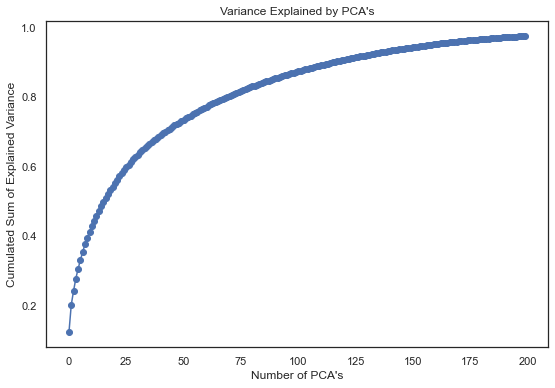

In [71]:
playlist_pca, saved_tracks_pca = preform_pca(playlist_all, saved_tracks_all, 200)

Now let's define some functions to identify the optimal number of clusters to cluster the playlist by:

In [72]:
def find_num_clusters(df, max_num = 50, plot = True):

    # get within cluster sum of squares for each value of k
    wcss = []
    max_clusters = min(max_num, df.shape[0])
    for i in range(1, max_clusters):
        kmeans_cluster = KMeans(i, init='k-means++', random_state=42)
        kmeans_cluster.fit(df)
        wcss.append(kmeans_cluster.inertia_)
    
    # programmatically locate the elbow
    n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
    if plot:
        print("Optimal number of clusters", n_clusters)
        # visualize the curve in order to locate the elbow
        fig = plt.figure(figsize=(20,8))
        plt.plot(range(1, max_clusters), wcss, marker='o', linestyle='--')
        plt.xlabel('Number of Clusters', fontsize=18)
        plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.show();
    return n_clusters, wcss[n_clusters-1]

See an example usage below:

Optimal number of clusters 13


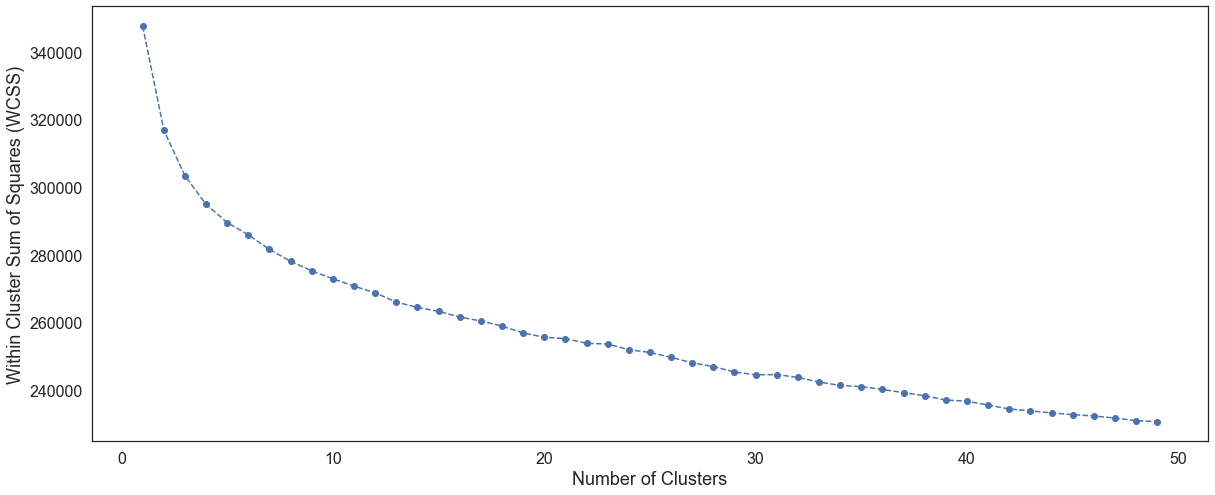

In [73]:
n_clusters, wcss = find_num_clusters(playlist_pca)

Now that we have functionality to reduce the dimension and then cluster our data sets, let's observe the quality of the clustering found for each data set:

In [74]:
def compare_dfs_cluster(df_list):
    '''
    Computes the within cluster sum of squares for the optimal number of clusters for each df in df_list.
    Returns a plotly figure displaying each metric for ease of comparison.
    '''

    df_wcss = []

    for df_name, playlist_df, saved_tracks_df in df_list:
        
        pca_playlist, pca_saved_tracks  = preform_pca(playlist_df, saved_tracks_df, 200, plot = False)
        n_clusters, wcss = find_num_clusters(pca_playlist, plot = False)
        df_wcss.append(wcss)
        
    # creating plot to display findings
    names = [value[0] for value in df_list]
    fig = go.Figure([go.Bar(x = names, y = df_wcss, name="Within Cluster Sum of Squares")])
    fig.update_yaxes(title="WCSS")
    return fig

In [75]:
clustering_fig = compare_dfs_cluster(df_list)

In [76]:
clustering_fig

We can see form the figure above that the best clustering are able to achieved in the `spotify_audio_features` and `spotify_audio_features_and_genres` data set. This makes sense as the spotify audio features are already a level of abstraction that captures differences in tracks well for Spotify's use. 

In [81]:
def recommend_songs_kmeans(playlist, playlist_name, saved_tracks, feat_names, num_songs_to_recommend):
    
    # apply PCA here, then cluster
    pca_playlist, pca_saved_tracks  = preform_pca(playlist, saved_tracks, 200, plot = False)
    
    # find optimal number of clusters
    n_clusters, wcss = find_num_clusters(pca_playlist, plot = False)
    
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(pca_playlist)
    pca_playlist['Cluster'] = kmeans.labels_
    
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn.fit(pca_saved_tracks)
    
    song_list=[]
    playlist_track_ids = [value[2] for value in pca_playlist.index]
    
    # for each cluster, recommend songs similar to the mean vector of songs in that cluster
    for i in np.arange(n_clusters):
        cluster_i_mean_vector = pca_playlist[pca_playlist['Cluster'] == i].mean().values[:-1]
        
        distances, indices = model_knn.kneighbors(cluster_i_mean_vector.reshape(1,-1), n_neighbors=num_songs_to_recommend)

        for i in range(0,len(distances.flatten())):
            if pca_saved_tracks.index[indices.flatten()[i]][2] not in playlist_track_ids:
                song_list.append(pca_saved_tracks.index[indices.flatten()[i]][2])
    
    # build Spotify playlist with recommendations
    token = utils.get_token()
    sp = spotipy.Spotify(auth=token)
    
    recom = sp.user_playlist_create('russyalgeo.','Recommendation for '+ playlist_name + ': ' + feat_names, public=True,
                                    collaborative=False,
                                    description=f'This Playlist has been created using Nearest Neigbor algorithm on {feat_names}')

    new_playlist_id = recom['id']  
    playlist_link = recom['external_urls']
    track_ids = set(song_list)
    
    if len(track_ids) > 100:
        rest_track_ids = track_ids
        while len(rest_track_ids) > 50:
            curr_track_ids = rest_track_ids[:50]
            rest_track_ids = rest_track_ids[50:]
            sp.playlist_add_items(new_playlist_id,curr_track_ids)
            token = utils.get_token()
            sp = spotipy.Spotify(auth = token)
        sp.playlist_add_items(new_playlist_id,rest_track_ids)
    else: 
        sp.playlist_add_items(new_playlist_id,track_ids)

    print('Recommendations for '+ playlist_name + ' created: ', playlist_link)

Now that we have everything that we need to recommend songs via K-Means, let's create a playlist of recommendations for each set of features now. All of the resulting playlists can be accessed at the links printed below!

In [82]:
for df_name, playlist_df, saved_tracks_df in df_list: 
    
    
    if df_name == 'spot_feats_genres':
        feat_names = 'Spotify Audio Features and Genres'
    elif df_name == 'calc_feats_genres':
        feat_names = 'Calculated Audio Features and Genres'
    else: 
        feat_names = 'All Features'
            
    recommend_songs_kmeans(playlist_df, playlist_name, saved_tracks_df, feat_names, 5)

Recommendations for Dune Juuz created:  {'spotify': 'https://open.spotify.com/playlist/3ZUavcBnw4EJlSl25NwZIh'}
Recommendations for Dune Juuz created:  {'spotify': 'https://open.spotify.com/playlist/0ASI85h22qapGUIMEyBAng'}
Recommendations for Dune Juuz created:  {'spotify': 'https://open.spotify.com/playlist/2PNWWsZe0jxDxTAzN1up1m'}


We've successfully made recommendations via utilizing errors in classification models and by looking at similar songs in terms of euclidean distance via K-Neighbors models. This method generalizes to much more than recommending from saved tracks for a playlist. For example, this tool could be used to speed up the music discovery process by recommending songs from a foreign playlist (one made by a another user that we wish to find good songs from) that show similarity to a playlist we wish to emulate the sound of!

In the future, I would like to convert this into a web tool so that other users can log in and perform the same type of analysis on their music libraries.